In [8]:
import numpy as np
import os
from skimage.io import imread
import cv2 as cv
from pathlib import Path
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

# Functions to load train and test images

In [9]:
def load_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []

    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]

    for _, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj) #zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA) # zwraca ndarray
                img = img / 255 #normalizacja
                train_img.append(img)
        categories_count.append(count)

    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X


In [3]:
data = load_train_data('./train_test_sw/train_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][50],data["labels"][200],data["labels"][300]])
print(list(data["values"][100][1][10]))

['Beech', 'Lemon', 'Tomato', 'Mean', 'Gardenia']
[203, 206, 206, 206, 206]
['Beech', 'Beech', 'Lemon']
[0.06666666666666667, 0.058823529411764705, 0.047058823529411764, 1.0]


In [4]:
def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)
    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']

    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)

    test_img = []
    labels=[]

    for e in objects:
        p = image_path / e['filename']
        img = imread(p)
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)
        img = img / 255
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X


In [5]:
data = load_test_data('./train_test_sw/test_sw')
print(data['categories_name'])
print(data['categories_count'])
print([data["labels"][10],data["labels"][20],data["labels"][30]])
print(list(data["values"][10][1][10]))

['Beech', 'Gardenia', 'Lemon', 'Mean', 'Tomato']
[51, 52, 52, 52, 52]
['Beech', 'Beech', 'Beech']
[0.058823529411764705, 0.00784313725490196, 0.0, 1.0]


# Make a train and test sets, plus encode labels

In [6]:
data_train = load_train_data("./train_test_sw/train_sw",newSize=(64,64))
X = data_train['values']
y_train = data_train['labels']

data_test = load_test_data("./train_test_sw/test_sw",newSize=(64,64))
X_test = data_test['values']
y_test = data_test['labels']

# Display 10 random images from training set

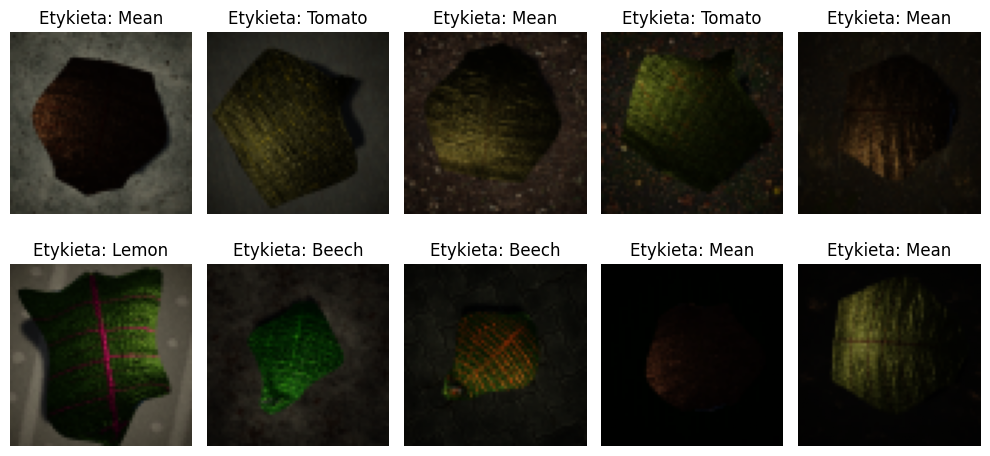

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
values = np.random.randint(1, 1000, 10)

for i, j in enumerate(values):
    axes[i].imshow(X[j], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y_train[j]}")

plt.tight_layout()

In [28]:
def plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val):
    
    fig , axes = plt.subplots(1, 2, figsize=(12, 8))
    ax1, ax2 = axes
    
    ax1.plot(losses_train, label='Training Loss')
    ax1.plot(losses_val, label='Validation Loss')
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
        
    ax2.plot(accuracies_train, label='Training Accuracy')
    ax2.plot(accuracies_val, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracies')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1 * (x > 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

activation_functions = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative)
}

# Neural Network

In [12]:
class NN:
    def __init__(self, input_size, hidden_size, output_size, act='sigmoid'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation_function = activation_functions[act][0]
        self.activation_function_derivative = activation_functions[act][1]

        self.w1 = np.random.randn(self.input_size, self.hidden_size)
        self.w2 = np.random.randn(self.hidden_size, self.output_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))

    def __str__(self) -> str:
        return f"Układ Sieci Neuronowej:\n \
                Warstwa Wejściowa: {self.input_size} neuronów\n \
                Warstwa Ukryta: {self.hidden_size} neuronów\n \
                Warstwa Wyjściowa: {self.output_size} neuronów\n"

    def __call__(self, X):
        z1 = (X @ self.w1) + self.b1
        self.a1 = self.activation_function(z1)
        z2 = self.a1 @ self.w2 + self.b2
        self.a2 = softmax(z2)
        return self.a2

    def backward(self, X, y, learning_rate):
        m = X.shape[0]

        dz2 = self.a2 - y
        dw2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = dz2 @ self.w2.T * self.activation_function_derivative(self.a1)
        dw1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2

In [13]:
def cross_entropy(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred))

In [14]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))

class_le = LabelEncoder()

y_train_enc = class_le.fit_transform(y_train)
y_test_enc = class_le.fit_transform(y_test)

X_train, X_val, y_train_enc, y_val_enc = train_test_split(X_scaled, y_train_enc, test_size=0.2, random_state=42)

In [15]:

def train(X_train, y_train_enc, 
          X_val, y_val_enc, 
          X_test, y_test_enc,
          epochs=1000, learning_rate=0.01, 
          hidden_shape=1024, activation='sigmoid'):
    
    losses_train, losses_val = [], []

    accuracies_train, accuracies_val = [], []

    input_shape = X_scaled.shape[1]
    output_shape = len(np.unique(y_train_enc))

    model = NN(input_shape, hidden_shape, output_shape, activation)

    for epoch in range(epochs+1):
        y_pred = model(X_train) 
        loss = cross_entropy(np.eye(output_shape)[y_train_enc], y_pred)
        model.backward(X_train, np.eye(output_shape)[y_train_enc], learning_rate)
        losses_train.append(loss/X_train.shape[0])

        accuracy_train = np.mean(y_train_enc == np.argmax(y_pred, axis=1))
        accuracies_train.append(accuracy_train)

        y_pred_val = model(X_val)
        loss_val = cross_entropy(np.eye(output_shape)[y_val_enc], y_pred_val)
        losses_val.append(loss_val/X_val.shape[0])

        accuracy_val = np.mean(y_val_enc == np.argmax(y_pred_val, axis=1))
        accuracies_val.append(accuracy_val)

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Train loss: {losses_train[-1]:.2f}, Val loss: {losses_val[-1]:.2f}")
            print(f"Train accuracy: {accuracy_train:.2%}, Val accuracy: {accuracy_val:.2%}")
            print()
    
    X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))
    y_pred_test = model(X_test_scaled)
    accuracy_test = np.mean(y_test_enc == np.argmax(y_pred_test, axis=1))
    print(f"Test accuracy: {accuracy_test:.2%}\n")

    return losses_train, losses_val, accuracies_train, accuracies_val
    

In [16]:
print(f'Train and test for: epochs=1000, learning_rate=0.01, hidden_shape=1024, activation=sigmoid\n\n')

losses_train, losses_val, accuracies_train, accuracies_val = train(X_train, y_train_enc, X_val, y_val_enc, X_test, y_test_enc, epochs=1000, learning_rate=0.01, hidden_shape=1024, activation='sigmoid')


Train and test for: epochs=1000, learning_rate=0.01, hidden_shape=1024, activation=sigmoid


Epoch: 0, Train loss: 24.15, Val loss: 23.04
Train accuracy: 20.83%, Val accuracy: 18.45%

Epoch: 100, Train loss: 7.86, Val loss: 10.01
Train accuracy: 35.32%, Val accuracy: 26.21%

Epoch: 200, Train loss: 5.65, Val loss: 9.13
Train accuracy: 44.58%, Val accuracy: 29.61%

Epoch: 300, Train loss: 4.32, Val loss: 8.72
Train accuracy: 52.86%, Val accuracy: 33.01%

Epoch: 400, Train loss: 3.42, Val loss: 8.48
Train accuracy: 59.93%, Val accuracy: 33.01%

Epoch: 500, Train loss: 2.75, Val loss: 8.27
Train accuracy: 65.29%, Val accuracy: 33.50%

Epoch: 600, Train loss: 2.23, Val loss: 8.10
Train accuracy: 71.13%, Val accuracy: 32.52%

Epoch: 700, Train loss: 1.82, Val loss: 7.95
Train accuracy: 74.67%, Val accuracy: 33.50%

Epoch: 800, Train loss: 1.48, Val loss: 7.84
Train accuracy: 77.59%, Val accuracy: 34.47%

Epoch: 900, Train loss: 1.21, Val loss: 7.74
Train accuracy: 81.00%, Val accuracy: 35.9

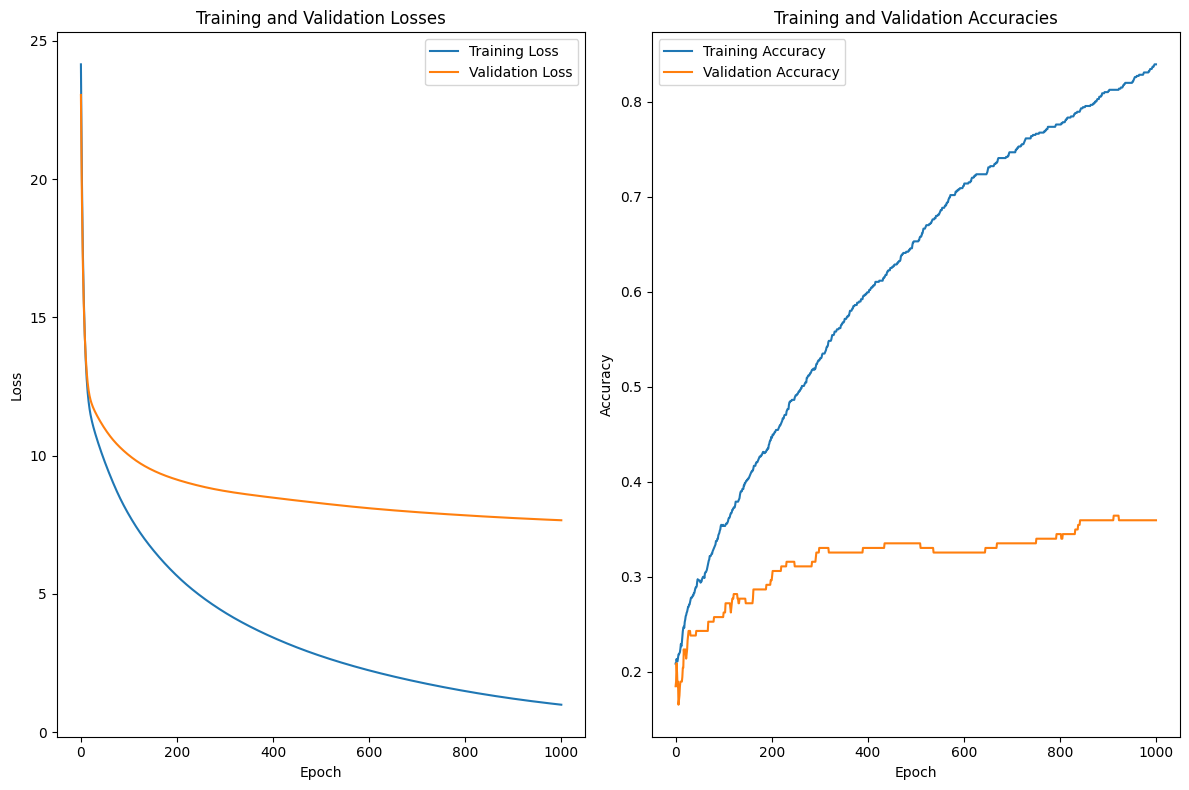

In [29]:
plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val)

In [34]:
print(f'Train and test for: epochs=200, learning_rate=0.1, hidden_shape=1024, activation=tanh\n\n')

losses_train, losses_val, accuracies_train, accuracies_val = train(X_train, y_train_enc, X_val, y_val_enc, X_test, y_test_enc, epochs=200, learning_rate=0.1, hidden_shape=1024, activation='tanh')

Train and test for: epochs=200, learning_rate=0.1, hidden_shape=1024, activation=tanh


Epoch: 0, Train loss: 44.12, Val loss: 91.89
Train accuracy: 19.61%, Val accuracy: 22.82%

Epoch: 100, Train loss: 31.87, Val loss: 30.13
Train accuracy: 69.67%, Val accuracy: 44.17%

Epoch: 200, Train loss: 0.15, Val loss: 11.73
Train accuracy: 99.51%, Val accuracy: 59.22%

Test accuracy: 67.18%



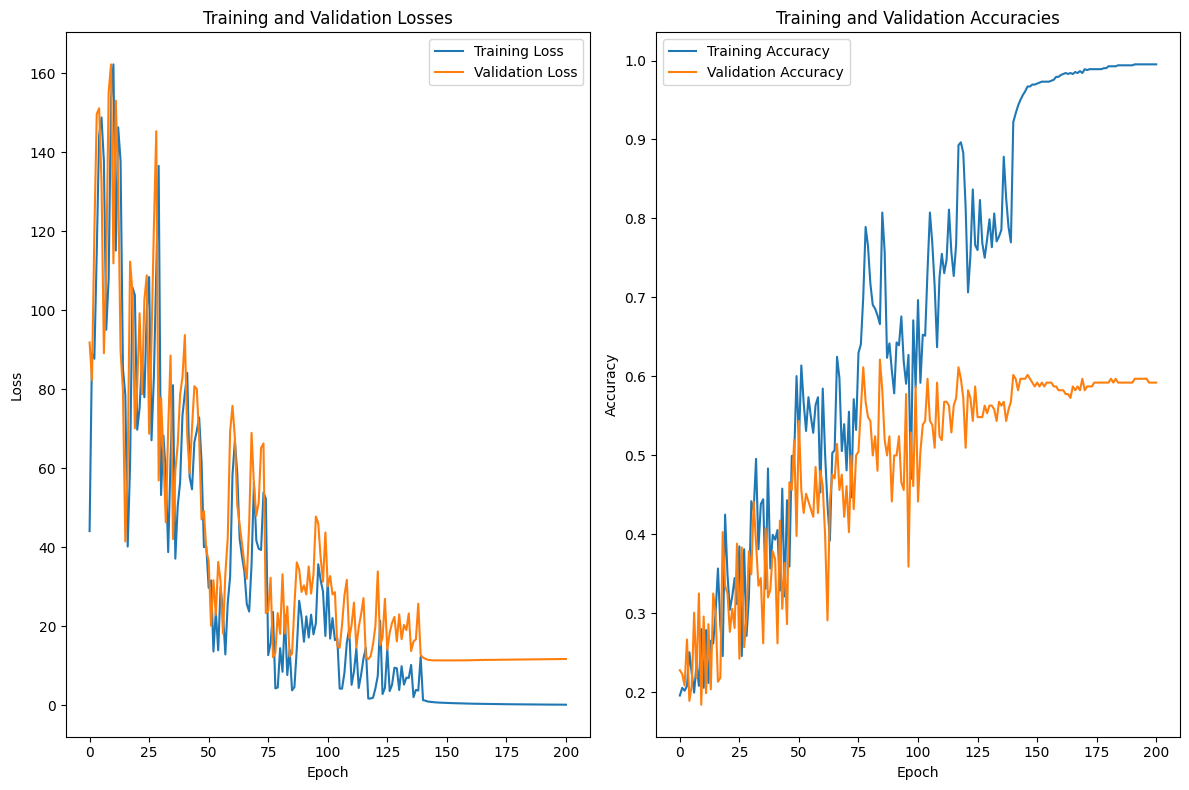

In [35]:
plot_loss_acc(losses_train, losses_val, accuracies_train, accuracies_val)

# Wnioski

Po przeprowadzeniu dwoch eksperymentow z roznymmi epochami, learning rate oraz funckjami aktywacji wychodiz na:

Lepsza byla funkcja aktywacji Tanh z learning rate 0.1 i epoch wynoszącymi 200, czas trenowania wyniósł - 3 min 54s, accuracy na secie treningowym wynosi 99,51%, na walidacyjnym 59,22% a testowym 67,18%.

Drugi eksperyment z funkcją aktywacji sigmoid, learning rate 0.001 oraz epoch 1000, byl zdecydowanie gorszy, czas trenowania wyniósł 16min 13s, accuracy na secie treningowym 83,92%, na walidacyjnym 35,92%, a testowtym 37,45% prawdopodobnie model overfituje podczas trenowania.